In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import itertools
import pickle

from nltk import ngrams

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, Bidirectional, TimeDistributed, Flatten, SpatialDropout1D
from keras.layers.merge import concatenate

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATASET_PATH = '../../data/ftb1u-v1/sentences'

In [3]:
bigram_size = 3

### Load train data

In [4]:
with open(f'{DATASET_PATH}/case_train_pos.pkl', 'rb') as f:
    train = pickle.load(f)

In [5]:
train[:5]

[[('Tammikuussa|NOUN', 'Ine'),
  ('hän|PRON', 'Nom'),
  ('muutti|VERB', 'Unk'),
  ('Ilkan|PROPN', 'Gen'),
  ('luokse|ADP', 'Unk'),
  ('Saviselkään|PROPN', 'Ill'),
  (',|PUNCT', 'Unk'),
  ('kevättalvi|NOUN', 'Nom'),
  ('koeteltiin|VERB', 'Unk'),
  ('toinen|PRON', 'Nom'),
  ('toisensa|DET', 'Gen'),
  ('luonnetta|NOUN', 'Par'),
  ('ja|CONJ', 'Unk'),
  ('kesällä|NOUN', 'Ade'),
  ('mentiin|VERB', 'Unk'),
  ('naimisiin|ADV', 'Unk'),
  ('.|PUNCT', 'Unk')],
 [('rakkaat|ADJ', 'Nom'),
  ('isä|NOUN', 'Nom'),
  ('ja|CONJ', 'Unk'),
  ('äiti|NOUN', 'Nom'),
  ('.|PUNCT', 'Unk')],
 [('Pitipä|VERB', 'Unk'), ('sattua|VERB', 'Lat'), ('.|PUNCT', 'Unk')],
 [('Nyt|ADV', 'Unk'), ('säästäminen|NOUN', 'Nom'), ('kannattaa|VERB', 'Unk')],
 [('Monet|PRON', 'Nom'),
  ('eivät|VERB', 'Unk'),
  ('vielä|ADV', 'Unk'),
  ('ole|VERB', 'Unk'),
  ('epäonnekseen|NOUN', 'Tra'),
  ('saaneet|VERB', 'Nom'),
  ('työpaikkaa|NOUN', 'Par'),
  ('.|PUNCT', 'Unk')]]

In [6]:
MAX_LENGTH = len(max(train, key=len))
MAX_LENGTH

72

In [7]:
MAX_LENGTH_CHAR = len(max((list(ngrams(t[0].rsplit('|', 1)[0], bigram_size)) for sent in train for t in sent), key=len))
MAX_LENGTH_CHAR

47

In [8]:
%%time
train_sentences, train_sentence_tags = [], [] 
for tagged_sentence in train:
    sentence, tags = zip(*tagged_sentence)
    train_sentences.append(np.array(sentence))
    train_sentence_tags.append(np.array(tags))

CPU times: user 123 ms, sys: 8.48 ms, total: 132 ms
Wall time: 129 ms


### Encode data

In [9]:
words, pos_tags, tags = set([]), set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w.lower().rsplit('|', 1)[0])
        
for s in train_sentences:
    for w in s:
        p = w.rsplit('|', 1)[-1]
        pos_tags.add(p)
        
l = []
for w in words:
    l += [''.join(bg) for bg in set(list(ngrams(w, bigram_size)))]
    if len(w) < bigram_size:
        l += [w]
bigrams = set(l)

for ts in train_sentence_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-OOV-'] = 1
word2index['-PAD-'] = 0

pos2index = {t: i + 2 for i, t in enumerate(list(pos_tags))}
pos2index['-OOV-'] = 1
pos2index['-PAD-'] = 0
 
tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0

char2index = {ch: i + 2 for i, ch in enumerate(list(bigrams))}
char2index['-OOV-'] = 1
char2index['-PAD-'] = 0
char2index[None] = 1

In [10]:
len(pos2index), len(tag2index), len(char2index)

(17, 18, 7023)

In [11]:
def encode_sentences(sentences, sentence_tags, max_len=MAX_LENGTH, max_len_char=MAX_LENGTH_CHAR, bigram_size=3):
    sentences_X, tags_y = [], []

    for s in sentences:
        s_int = []
        for w in s:
            try:
                w = w.rsplit('|', 1)
                s_int.append(pos2index[w[-1]])
            except KeyError:
                s_int.append(pos2index['-OOV-'])

        sentences_X.append(s_int)

    for s in sentence_tags:
        tags_y.append([tag2index[t] for t in s])

    # chars encoding
    chars_X = np.zeros((len(sentences), max_len, max_len_char))
    for i, sentence in enumerate(sentences):
        for j, word in enumerate(sentence):
            word = word.lower().rsplit('|', 1)[0]
            if len(word) < bigram_size:
                word_ngrams = [word]
            else:
                word_ngrams = list(ngrams(word, bigram_size))
                
            for k, bg in enumerate(word_ngrams):
                if j < MAX_LENGTH and k < MAX_LENGTH_CHAR:
                    chars_X[i, j, k] = char2index.get(''.join(bg), char2index["-OOV-"])
    return sentences_X, chars_X, tags_y

In [12]:
%%time
train_sentences_X, train_chars_X, train_tags_y = encode_sentences(train_sentences, train_sentence_tags, bigram_size=bigram_size)

CPU times: user 1.38 s, sys: 64.6 ms, total: 1.45 s
Wall time: 1.46 s


In [13]:
train_sentences_X[0]

[3, 4, 14, 10, 16, 10, 5, 3, 14, 4, 6, 3, 7, 3, 14, 13, 5]

In [14]:
train_chars_X[0][0]

array([5072., 5200., 2679., 2148., 1408.,  151., 6416., 6479., 3876.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.])

### Load test data

In [15]:
with open(f'{DATASET_PATH}/case_test_pos.pkl', 'rb') as f:
    test = pickle.load(f)

In [16]:
test[:5]

[[('Bajul|PROPN', 'Nom'),
  ('ei|VERB', 'Unk'),
  ('kauan|ADV', 'Unk'),
  ('viihdy|VERB', 'Unk'),
  ('ammattilaisena|NOUN', 'Ess'),
  ('.|PUNCT', 'Unk')],
 [('mennä|VERB', 'Lat'), ('päivälliselle|NOUN', 'All')],
 [('Pihassamme|NOUN', 'Ine'),
  ('kasvaa|VERB', 'Unk'),
  ('koivun|NOUN', 'Gen'),
  ('juurella|ADP', 'Unk'),
  ('sitkeä|ADJ', 'Nom'),
  (',|PUNCT', 'Unk'),
  ('ikivihreä|ADJ', 'Nom'),
  ('kasvi|NOUN', 'Nom'),
  ('.|PUNCT', 'Unk')],
 [('En|VERB', 'Unk'),
  ('oo|VERB', 'Unk'),
  ('itte|PRON', 'Nom'),
  ('ainakaan|ADV', 'Unk'),
  ('vielä|ADV', 'Unk'),
  ('harrastanut|VERB', 'Nom'),
  ('tota|DET', 'Par'),
  ('yöllä|NOUN', 'Ade'),
  ('syömistä|NOUN', 'Par'),
  ('.|PUNCT', 'Unk')],
 [('Työttömyyteen|NOUN', 'Ill'),
  ('on|VERB', 'Unk'),
  ('käytävä|VERB', 'Nom'),
  ('käsiksi|ADV', 'Unk'),
  ('kaikella|DET', 'Ade'),
  ('sillä|DET', 'Ade'),
  ('tarmolla|NOUN', 'Ade'),
  (',|PUNCT', 'Unk'),
  ('joka|PRON', 'Nom'),
  ('meistä|DET', 'Ela'),
  ('suomalaisista|ADJ', 'Ela'),
  ('löytyy|VERB',

In [17]:
%%time
test_sentences, test_sentence_tags = [], [] 
for tagged_sentence in test:
    sentence, tags = zip(*tagged_sentence)
    test_sentences.append(np.array(sentence))
    test_sentence_tags.append(np.array(tags))

CPU times: user 21.8 ms, sys: 3.79 ms, total: 25.6 ms
Wall time: 25.8 ms


In [18]:
%%time
test_sentences_X, test_chars_X, test_tags_y = encode_sentences(test_sentences, test_sentence_tags, bigram_size=bigram_size)

CPU times: user 354 ms, sys: 11.9 ms, total: 366 ms
Wall time: 369 ms


#### Padding

In [19]:
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

In [20]:
train_sentences_X.shape, train_tags_y.shape

((15277, 72), (15277, 72))

In [21]:
test_sentences_X.shape, test_tags_y.shape

((3820, 72), (3820, 72))

### Define model and evaluation functions

In [22]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
batch_size = 64

vocab_size = len(word2index)
vocab_char_size = len(char2index)
classes = len(tag2index)

dropout = 0.2
lstm_recurrent_dropout = 0.2

In [24]:
## Word Input
word_in = Input(shape=(MAX_LENGTH,), name='pos_input')

word_embeddings = Embedding(input_dim=vocab_size,
                            output_dim=16,
                            input_length=MAX_LENGTH,
                            mask_zero=False,
                            name='pos_embedding')(word_in)
word_enc = Bidirectional(LSTM(units=16, return_sequences=True, 
                dropout=dropout, recurrent_dropout=lstm_recurrent_dropout,
                name='pos_encoder'))(word_embeddings)

# Character Input
char_in = Input(shape=(MAX_LENGTH, MAX_LENGTH_CHAR,), name='char_input')

# Character Embedding
emb_char = TimeDistributed(Embedding(input_dim=vocab_char_size, output_dim=96, 
                           input_length=MAX_LENGTH_CHAR, mask_zero=False),
                          name='char_embedding')(char_in)
# Character Sequence to Vector via BiLSTM
char_enc = TimeDistributed(Bidirectional(LSTM(units=96, return_sequences=False, dropout=dropout, 
                                              recurrent_dropout=lstm_recurrent_dropout),
                           name='char_encoder'))(emb_char)

# Concatenate All Embedding
all_word_embeddings = concatenate([word_enc, char_enc])
all_word_embeddings = SpatialDropout1D(0.15)(all_word_embeddings)

# Main Model BiLSTM
word_feats_enc = Bidirectional(LSTM(units=48, return_sequences=True, 
                 dropout=dropout, recurrent_dropout=lstm_recurrent_dropout, 
                 name='main_encoder'))(all_word_embeddings)

out = Dense(classes, activation='softmax', name='case_decoder')(word_feats_enc)

# Model
model = Model([word_in, char_in], out)

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision_m, recall_m, f1_m])

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pos_input (InputLayer)          (None, 72)           0                                            
__________________________________________________________________________________________________
char_input (InputLayer)         (None, 72, 47)       0                                            
__________________________________________________________________________________________________
pos_embedding (Embedding)       (None, 72, 16)       599472      pos_input[0][0]                  
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 72, 47, 96)   674208      char_input[0][0]                 
____________________________________________________________________________________________

### Fit model

In [27]:
history = model.fit([train_sentences_X, train_chars_X], to_categorical(train_tags_y, len(tag2index)),
                    epochs=10, verbose=1,
                    validation_data=([test_sentences_X, test_chars_X], to_categorical(test_tags_y, len(tag2index))))

Train on 15277 samples, validate on 3820 samples
Epoch 1/10
15277/15277 [==============================] - 1035s 68ms/step - loss: 0.2420 - accuracy: 0.9355 - precision_m: 0.9657 - recall_m: 0.9042 - f1_m: 0.9329 - val_loss: 0.1292 - val_accuracy: 0.9576 - val_precision_m: 0.9918 - val_recall_m: 0.9423 - val_f1_m: 0.9664
Epoch 2/10
15277/15277 [==============================] - 1009s 66ms/step - loss: 0.0932 - accuracy: 0.9706 - precision_m: 0.9921 - recall_m: 0.9572 - f1_m: 0.9744 - val_loss: 0.0582 - val_accuracy: 0.9816 - val_precision_m: 0.9909 - val_recall_m: 0.9740 - val_f1_m: 0.9824
Epoch 3/10
15277/15277 [==============================] - 1010s 66ms/step - loss: 0.0471 - accuracy: 0.9858 - precision_m: 0.9922 - recall_m: 0.9803 - f1_m: 0.9862 - val_loss: 0.0305 - val_accuracy: 0.9910 - val_precision_m: 0.9943 - val_recall_m: 0.9886 - val_f1_m: 0.9915
Epoch 4/10
15277/15277 [==============================] - 1004s 66ms/step - loss: 0.0276 - accuracy: 0.9919 - precision_m: 0.9947

### Evaluate train model

In [28]:
scores, acc, p, r, f = model.evaluate([train_sentences_X, train_chars_X], to_categorical(train_tags_y, len(tag2index)))
scores, acc, p, r, f

15277/15277 [==============================] - 310s 20ms/step


(0.004186382611016862,
 0.9987545013427734,
 0.9988819360733032,
 0.9986769556999207,
 0.9987787008285522)

#### Plot scores

In [29]:
from matplotlib import pyplot as plt

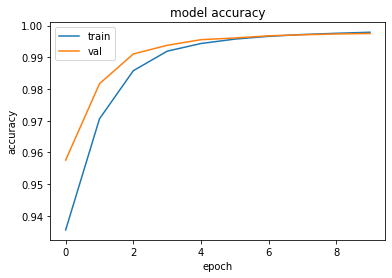

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

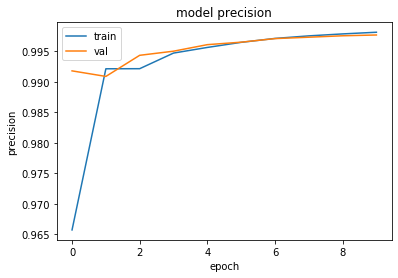

In [31]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

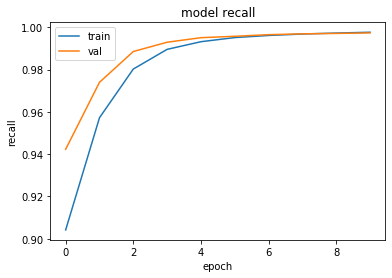

In [32]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

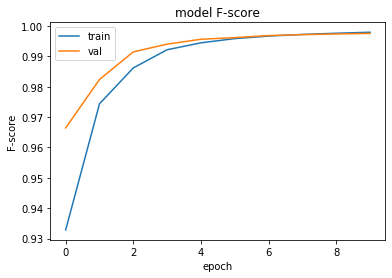

In [33]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F-score')
plt.ylabel('F-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

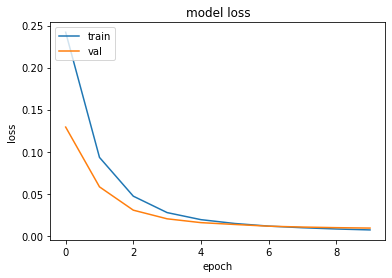

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate test dataset

In [35]:
scores, acc, p, r, f = model.evaluate([test_sentences_X, test_chars_X], to_categorical(test_tags_y, len(tag2index)))
scores, acc, p, r, f

3820/3820 [==============================] - 77s 20ms/step


(0.009182124597590944,
 0.9974985718727112,
 0.997679591178894,
 0.9973719716072083,
 0.9975256323814392)

### Make predictions

In [36]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequences.append([index[cat] for cat in np.argmax(categorical_sequence, axis=1)])
 
    return token_sequences

In [37]:
inverted_tag_index = {i: t for t, i in tag2index.items()}

In [38]:
%%time
predictions = model.predict([test_sentences_X, test_chars_X])

CPU times: user 4min 24s, sys: 4.72 s, total: 4min 29s
Wall time: 1min 16s


In [39]:
%%time
pred_labels = logits_to_tokens(predictions, inverted_tag_index)

CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 128 ms


In [40]:
pred_labels[:5]

[['Nom',
  'Unk',
  'Unk',
  'Unk',
  'Ess',
  'Unk',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-'],
 ['Lat',
  'All',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '-PAD-',
  '

### Classification report

In [41]:
y_true = [inverted_tag_index[t] for l in test_tags_y for t in l]
y_pred = list(itertools.chain(*pred_labels))

In [42]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       -PAD-       1.00      1.00      1.00    242650
         Abe       0.97      0.86      0.91        42
         Abl       0.96      0.99      0.98       189
         Acc       0.96      0.96      0.96        25
         Ade       0.99      1.00      0.99       649
         All       0.99      0.99      0.99       359
         Com       0.93      0.72      0.81        18
         Ela       0.91      0.98      0.94       703
         Ess       0.98      0.98      0.98       333
         Gen       0.95      0.96      0.95      2795
         Ill       0.95      0.94      0.95       817
         Ine       1.00      0.99      0.99       842
         Ins       0.76      0.58      0.66        67
         Lat       0.93      0.94      0.94       649
         Nom       0.97      0.96      0.97      6089
         Par       0.96      0.96      0.96      2428
         Tra       0.97      0.98      0.97       214
         Unk       1.00    

### Build confusion matrices

In [43]:
labels = list(sorted(set(y_true)))
array = confusion_matrix(y_true=y_true, y_pred=y_pred)

Precision

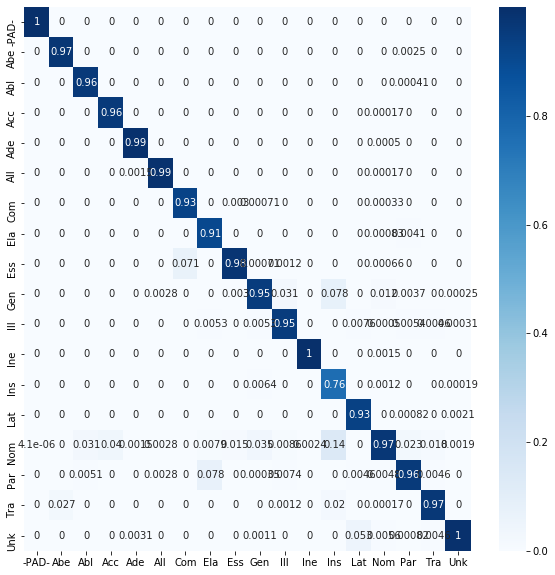

In [44]:
df_cm_1 = pd.DataFrame(array / array.sum(axis=0), index = labels, columns = labels)

plt.figure(figsize = (10,10))
sns.heatmap(df_cm_1, annot=True, cmap=plt.cm.Blues)
plt.show() 

Recall

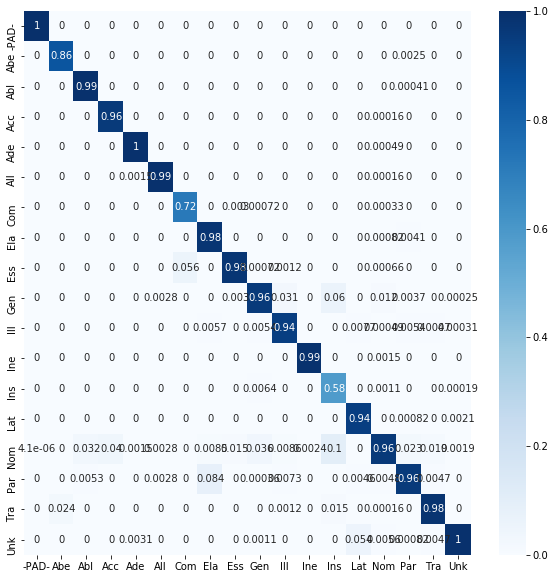

In [45]:
df_cm_2 = pd.DataFrame(array / array.sum(axis=1), index = labels, columns = labels)

plt.figure(figsize = (10,10))
sns.heatmap(df_cm_2, annot=True, cmap=plt.cm.Blues)
plt.show()